# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 01.12.2022

Мягкий дедлайн: 23:59MSK 11.12.2022

Жесткий дедлайн: 23:59MSK 15.12.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style('whitegrid')

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

/home/kvdmitrieva/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing 

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.89054534897418

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    n = X.shape[0]
    all_preds = np.full((n, num_runs), np.nan)
    error = 0.
    
    for i in range(num_runs):
        inds = np.random.randint(0, n, n)
        regressor.fit(X[inds], y[inds])
        
        out_of_bag = list({x for x in range(n)} - set(inds))
        prediction = regressor.predict(X[out_of_bag])
        
        all_preds[out_of_bag, i] = prediction
        error += sum((y[out_of_bag] - prediction) ** 2)
        
    count_preds = (np.isnan(all_preds) ^ 1).sum(axis=1)
    inds = count_preds.astype(bool)
    
    bias = ((y[inds] - np.nanmean(all_preds[inds], axis=1)) ** 2).mean()
    variance = np.nanvar(all_preds[inds], axis=1).mean()
    error = error / sum(count_preds) if sum(count_preds) else 0.
    
    return bias, variance, error
        

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


regressors = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
for reg in regressors:
    print(reg)
    bias, variance, error = compute_biase_variance(reg, X, y)
    print(f"bias = {bias:.2f}, variance = {variance:.2f}, error = {error:.2f}")
    print(f"sanity check: b+v = {bias + variance:.2f}, error = {error:.2f}\n")
    

LinearRegression()
bias = 23.68, variance = 0.92, error = 24.65
sanity check: b+v = 24.60, error = 24.65

DecisionTreeRegressor()
bias = 10.37, variance = 12.93, error = 23.30
sanity check: b+v = 23.30, error = 23.30

RandomForestRegressor()
bias = 10.55, variance = 2.24, error = 12.70
sanity check: b+v = 12.78, error = 12.70



__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

Из занятий знаем, что 
- линейная модель имеет маленькую дисперсию (устойчива к небольшим изменениям выборки), но может иметь большое смещение, если в данных более сложные завиимости
- решающее дерево достаточно сложная модель и может достигать нулевой ошибки, а значит иметь меньшее смещение, но при этом очень неустойчиво к изменению в обучающих данных (большая дисперсия)
- случайный лес будет иметь примерно такое же смещение, что и дерево, но должен сильно уменьшить разброс

Полученные результаты согласуются с тем, что обсуждалось на занятиях


__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

На лекциях доказывалось, что если базовые модели некоррелированы, то разброс может уменьшиться в N раз, где N - количество базовых моделей в бэггинге, иначе изменения дисперсии будут менее существенны

По умолчанию в `BaggingRegressor` берется 10 моделей, т.е. мы ожидаем уменьшение разброса в 10 раз. Рассмотрим полученные ниже результаты:
- линейная модель не улучшила показатель разброса --- модель изначально была устойчива к изменениям данных и соответственно в бэггинге мы получили 10 скоррелированных моделей, отсюда нет желаемого результа
- дерево уменьшило разброс почти в 4 раза --- на разных подвыборках деревья будут получаться достаточно разнообразными, поэтому есть существенное изменение в разбросе, но в любом случае некоторая корреляция между моделями будет присутствовать, из-за чего не получили уменьшение в 10 раз
- лес немного уменьшил разброс, но оно и понятно - у нас получается условно бэггинг над бэггингом, т.е. уже не ожидаем сильного изменения 

In [9]:
from sklearn.ensemble import BaggingRegressor


regressors = [BaggingRegressor(LinearRegression()), 
              BaggingRegressor(DecisionTreeRegressor()), 
              BaggingRegressor(RandomForestRegressor())]


for reg in regressors:
    print(reg)
    bias, variance, error = compute_biase_variance(reg, X, y)
    print(f"bias = {bias:.2f}, variance = {variance:.2f}, error = {error:.2f}")
    print(f"sanity check: b+v = {bias + variance:.2f}, error = {error:.2f}\n")


BaggingRegressor(base_estimator=LinearRegression())
bias = 23.70, variance = 1.03, error = 24.81
sanity check: b+v = 24.73, error = 24.81

BaggingRegressor(base_estimator=DecisionTreeRegressor())
bias = 10.53, variance = 3.40, error = 14.04
sanity check: b+v = 13.93, error = 14.04

BaggingRegressor(base_estimator=RandomForestRegressor())
bias = 11.60, variance = 1.39, error = 13.03
sanity check: b+v = 12.99, error = 13.03



### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [10]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax=None):
    """
    plot graphics described above
    """
    n = X.shape[0]
    perm = np.random.permutation(range(n))
    test_inds = perm[:num_test_objects]
    train_inds = perm[num_test_objects:]
    
    for i in range(num_runs):
        inds = np.random.choice(train_inds, n - num_test_objects)
        regressor.fit(X[inds], y[inds])
        pred = regressor.predict(X[test_inds])
        sns.scatterplot(x=range(num_test_objects), y=pred, color='red', ax=ax)
        
    sns.scatterplot(x=range(num_test_objects), y=y[test_inds], color='black', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('test object')
    ax.set_ylabel('prediction')
    

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

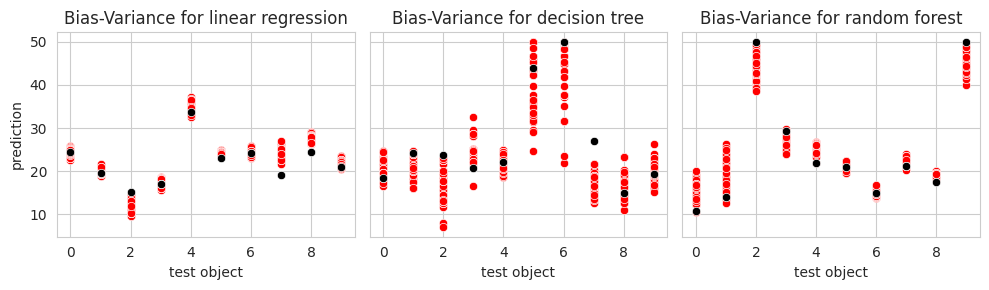

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(10,3), sharey=True)

plot_predictions(LinearRegression(), X, y, title="Bias-Variance for linear regression", ax=ax[0])
plot_predictions(DecisionTreeRegressor(), X, y, title="Bias-Variance for decision tree", ax=ax[1])
plot_predictions(RandomForestRegressor(), X, y, title="Bias-Variance for random forest", ax=ax[2])

fig.tight_layout()

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

Общий принцип: если предсказания для объекта близко находятся - маленький разброс, если истинный ответ примерно посередине предсказаний - маленький разброс

- линейная модель - большинство предсказаний хорошо кучкуются - свидетельство маленького разброса, а вот истинный ответ редко попадает в центр предсказаний, может даже совсем сильно отличаться - большой разброс
- дерево - истинный ответ попадает примерно в середину предсказаний - маленькое смещение, но вот разброс предсказаний сильный
- у леса оба показателя радуют: почти у всех объектов очень маленький разброс предсказаний, а истиный ответ попадает рядом с центром предсказаний

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

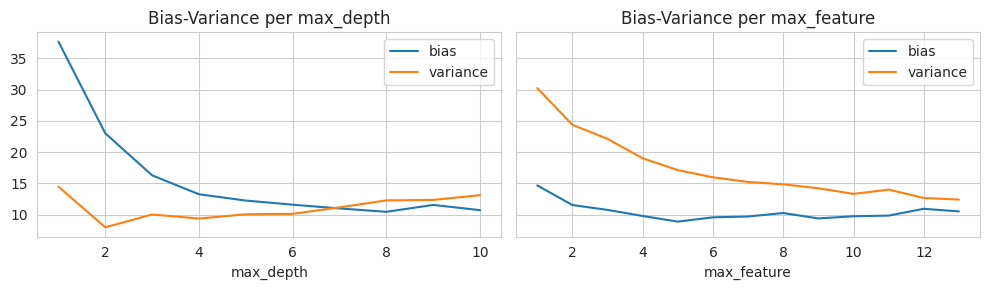

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

bias = []
var = []

for i in range(10):
    tree = DecisionTreeRegressor(max_depth=i + 1)
    b, v, _ = compute_biase_variance(tree, X, y, 100)
    bias.append(b)
    var.append(v)
    
sns.lineplot(x=range(1, 11), y=bias, ax=ax[0], label='bias')
sns.lineplot(x=range(1, 11), y=var, ax=ax[0], label='variance')
ax[0].set_title("Bias-Variance per max_depth")
ax[0].set_xlabel("max_depth")


bias = []
var = []

for i in range(X.shape[1]):
    tree = DecisionTreeRegressor(max_features=i + 1)
    b, v, _ = compute_biase_variance(tree, X, y, 100)
    bias.append(b)
    var.append(v)
    
sns.lineplot(x=range(1, X.shape[1] + 1), y=bias, ax=ax[1], label='bias')
sns.lineplot(x=range(1, X.shape[1] + 1), y=var, ax=ax[1], label='variance')
ax[1].set_title("Bias-Variance per max_feature")
ax[1].set_xlabel("max_feature")
ax[1].set_ylabel("bias-variance")

fig.tight_layout()
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

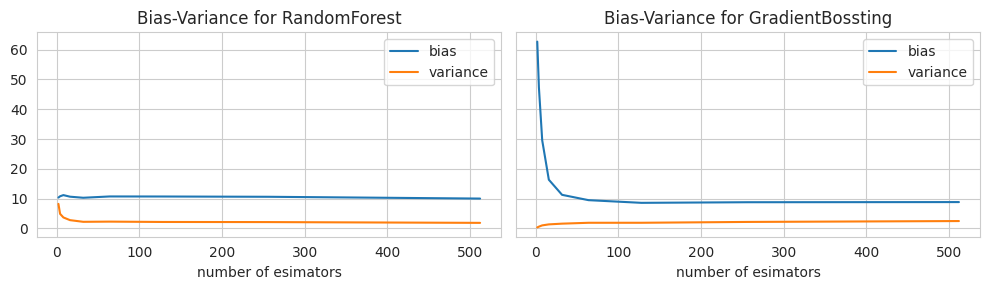

In [13]:
from sklearn.ensemble import GradientBoostingRegressor


forest_bias = []
forest_var = []

boosting_bias = []
boosting_var = []

grid = 2 ** np.arange(1, 10)
for i in grid:
    forest = RandomForestRegressor(n_estimators=i)
    boosting = GradientBoostingRegressor(n_estimators=i)
    
    b, v, _ = compute_biase_variance(forest, X, y, 100)
    forest_bias.append(b)
    forest_var.append(v)
    
    b, v, _ = compute_biase_variance(boosting, X, y, 100)
    boosting_bias.append(b)
    boosting_var.append(v)
    
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

sns.lineplot(x=grid, y=forest_bias, ax=ax[0], label='bias')
sns.lineplot(x=grid, y=forest_var, ax=ax[0], label='variance')
ax[0].set_title("Bias-Variance for RandomForest")
ax[0].set_xlabel("number of esimators")

sns.lineplot(x=grid, y=boosting_bias, ax=ax[1], label='bias')
sns.lineplot(x=grid, y=boosting_var, ax=ax[1], label='variance')
ax[1].set_title("Bias-Variance for GradientBossting")
ax[1].set_xlabel("number of esimators")
ax[1].set_ylabel("bias-variance")

fig.tight_layout()
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__


- С увеличением максимальной глубины модель усложняется, а значит может делать лучше предсказание (уменьшает смещение), но при этом сильнее переобучается (увеличивается дисперсия)

- На втором графике смещение почти не меняется, но разброс уменьшается - при небольшом числе рассматриваемых признаков мы увеличиваем случайность в данных, на которых обучаемся, а деревья не устойчивы к изменениям

- Случайный лес - в силу своих свойств не меняет смещение, при этом как мы видим разброс упал до минимума почти сразу, т.е. даже 2 деревьев в ансамбле хватает в данном случае, чтобы уменьшить разброс, а начиная с определенного момента уже не имеет смыла увеличивать количество моделей

- На четвертом графике разброс немного подрос - переобучаемся на большом количестве моделей, а вот смещение сильно падает на первых нескольких итерациях - ошибка алгоритма целенаправлено снижается с каждой новой моделью

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__